In [1]:
import os
import lsdb
import numpy as np
import pandas as pd
import photod.locus as lt
import photod.bayes as bt
pd.set_option('display.max_columns', None)

Read photometric catalog with stars, for this we already prepared a small dataset based on SDSS S82.

Željko's pipeline example based on simulated TRILEGAL data had additionally the following cuts (only the first one can be implemented in S82): 
 - The input data are limited to 0.2 < g-i < 3.0 and 
 - -2.5 < FeH < 0 (probably OK in S82, maybe a few outliers) 
 - Mr > -1.0 (no very bright giants)
 - log(g) < 7 (no WDs, probably a small fraction exists in S82)
 - rmag < 26 (SDSS limiting mag is r~24, so this is not needed)

In [2]:
from dask.distributed import Client

client = Client(n_workers=96, threads_per_worker=1, memory_limit="15GiB")
client

/home/scampos/photoD/.venv/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39773 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39773/status,
Dashboard: http://127.0.0.1:39773/status,Workers: 96
Total threads: 96,Total memory: 1.41 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35765,Workers: 96
Dashboard: http://127.0.0.1:39773/status,Total threads: 96
Started: Just now,Total memory: 1.41 TiB
Comm: tcp://127.0.0.1:35929,Total threads: 1
Dashboard: http://127.0.0.1:40889/status,Memory: 15.00 GiB
Nanny: tcp://127.0.0.1:35689,


In [3]:
%%time 
s82 = lsdb.read_hats("/mnt/beegfs/scratch/data/S82_standards/S82_hats/S82_hats_fixed/")
#s82.skymap(lambda df, a: np.log10(len(df)+1), order=9)

CPU times: user 45.4 ms, sys: 4.55 ms, total: 50 ms
Wall time: 51.1 ms


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - S82_fixed'}>)

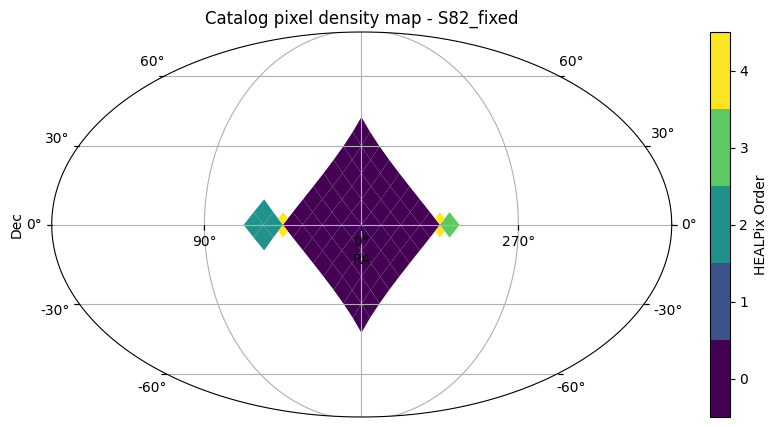

In [4]:
s82.plot_pixels()

Next, read the stellar locus parametrization.

In [5]:
LSSTlocus = lt.LSSTsimsLocus(fixForStripe82=False, datafile="/home/scampos/photoD/data/MSandRGBcolors_v1.3.txt") # fixForStripe82 was originally set to False
## select the color range where we expect main sequence and red giants
OKlocus = LSSTlocus[(LSSTlocus['gi']>0.2)&(LSSTlocus['gi']<3.55)]   # gives MrMax < 15 (rerun priors!)

Subsample Mr and FeH grids (linear speed-up but somewhat lower accuracy)

In [6]:
kMr = 10 # 10x less samples
kFeH = 2 # 2x less samples
locusData = lt.subsampleLocusData(OKlocus, kMr, kFeH)

subsampled locus 2D grid in FeH and Mr from 51 1559 to: 25 155


Prepare the priors, see TRILEGAL-makePriors-forS82.ipynb notebook (work in progress).

Process data...

In [7]:
fitColors = ('ug', 'gr', 'ri', 'iz')
pix_order = 5
pix_index = 0
priorsRootName = f'/mnt/beegfs/scratch/scampos/photod/priors/TRILEGAL/S82/{pix_order}/{pix_index}'
outfile = 'results/S82_Bayes_estimates.txt'

Make 3D locus list with three ArGrid limits and resolutions.

In [8]:
ArGridList, locus3DList = lt.get3DmodelList(locusData, fitColors)

Select a range of stars to process.

In [9]:
df = s82.pixel_search([(pix_order,pix_index)]).compute()

In [10]:
iStart = 0
iEnd = len(df) # if<0: do all stars
# myStars = [0, 100, 1000, 10000] # for illustration, make plots for these stars
# myStars = [10, 233] # no plots
verb=False

In [11]:
os.makedirs("plots", exist_ok=True)
os.makedirs("results", exist_ok=True)

In [12]:
import cProfile

with cProfile.Profile() as pr:
    bt.makeBayesEstimates3D(
        df.reset_index(drop=True), # Pandas DF
        fitColors, # tuple
        locusData, # Pandas DF (before astropy Table)
        locus3DList, # dict of structured np arrays
        ArGridList, # dict of np arrays
        priorsRootName, # str
        outfile, # str
        iStart, # int
        iEnd, # int
        verbose=verb # bool
    )
    pr.dump_stats("/home/scampos/photoD/bayes-3d.pstat")

Mr1d= -1.0 14.4 155
MrBright, MrFaint= -1.0 14.4


/home/scampos/photoD/src/photod/bayes.py:169: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  catalog["chi2min"][i] = np.min(chi2map)
/home/scampos/photoD/src/photod/bayes.py:144: FutureWarning: ChainedAssignmentError: behaviour will change in